# This notebook was prepared by Taras Semenchenko

In [1]:
# from google.colab import drive, files
# drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# !sudo apt-get install unzip
# !unzip 'drive/MyDrive/kyivstar/archive.zip' -d 'data'

In [3]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import torch.nn.functional as F

import time
import os
import PIL.Image as Image
from IPython.display import display

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

cuda:0
Tesla T4


# Loading and Standardizing data

In [ ]:
dataset_dir = 'data/car_data/car_data/'

train_tfms = transforms.Compose([transforms.Resize((224, 224)),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406],
                                                      [0.229, 0.224, 0.225])
])

test_tfms = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])
])

dataset = torchvision.datasets.ImageFolder(root=dataset_dir + "train", transform = train_tfms)
trainloader = torch.utils.data.DataLoader(dataset, batch_size = 32, shuffle=True, num_workers = 4)

dataset2 = torchvision.datasets.ImageFolder(root=dataset_dir + "test", transform = test_tfms)
testloader = torch.utils.data.DataLoader(dataset2, batch_size = 32, shuffle=False, num_workers = 4)



# Defining train and evaluate functions

In [4]:
def eval_model(model):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model_ft(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = correct / total * 100
    
    print('Test accuracy:', test_acc)
    
    return test_acc

In [5]:
def train_model(model, criterion, optimizer, scheduler, n_epochs=5):    
    losses = []
    accuracies = []
    test_accuracies = []
    model.train()
    for epoch in range(n_epochs):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        epoch_duration = time.time()-since
        epoch_loss = running_loss/len(trainloader)
        epoch_acc = 100/32*running_correct/len(trainloader)
        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        model.eval()        
        
        test_acc = eval_model(model)
        test_accuracies.append(test_acc)
        
        model.train()
        scheduler.step()
        since = time.time()
    print('Finished Training')
    return model, losses, accuracies, test_accuracies

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd

def plot_results(training_accs, training_losses, test_accs):

    fig, ax = plt.subplots(1, 2, figsize=(16, 6))

    sns.lineplot(x=range(len(training_accs)), y=training_accs, ax=ax[0])
    sns.lineplot(x=range(len(test_accs)), y=test_accs, ax=ax[0])

    sns.lineplot(x=range(len(training_losses)), y=training_losses, ax=ax[1])

    ax[0].set_title('Train-Test Accuracy')
    ax[1].set_title('Train Loss')

    ax[0].set(xlabel='epoch', ylabel='accuracy')
    ax[1].set(xlabel='epoch', ylabel='loss')

    ax[0].legend(['train', 'test'])
    ax[1].legend(['train'])

    plt.show()

# Defining convolutional neural networks

# Model with 1 convolutional layer

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(6 * 112 * 112, 196)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))        
        x = x.view(-1, 6 * 112 * 112)
        logits = self.fc1(x)
        
        return logits

model_ft = Net()

In [ ]:
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)
lrscheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

In [ ]:
model_ft, training_losses, training_accs, test_accs = train_model(model_ft,
                                                                  criterion,
                                                                  optimizer_ft,
                                                                  lrscheduler, 
                                                                  n_epochs=5)

Epoch 1, duration: 25 s, loss: 6.2299, acc: 1.3603
Test accuracy: 1.890312150230071
Epoch 2, duration: 25 s, loss: 4.2602, acc: 14.1912
Test accuracy: 2.2136550180325827
Epoch 3, duration: 25 s, loss: 3.0718, acc: 37.8064
Test accuracy: 2.748414376321353
Epoch 4, duration: 26 s, loss: 1.7513, acc: 69.4485
Test accuracy: 2.8603407536376073
Epoch 5, duration: 24 s, loss: 0.7249, acc: 91.4338
Test accuracy: 3.2707374704638728
Finished Training


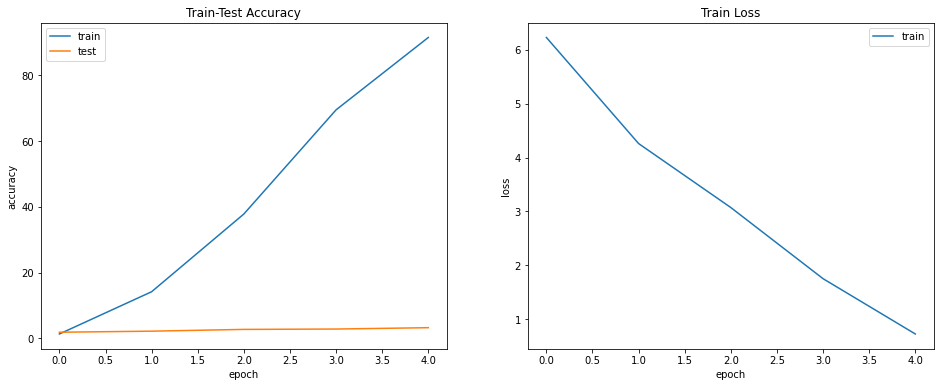

In [ ]:
plot_results(training_accs, training_losses, test_accs)

# Model with 2 convolutional layers

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 3, padding=1)      
        self.conv2 = nn.Conv2d(6, 12, 3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(12 * 56 * 56, 196)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(-1, 12 * 56 * 56)
        logits = self.fc1(x)
        
        return logits
    
model_ft = Net()

In [ ]:
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)
lrscheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=100, gamma=0.1)

In [ ]:
model_ft, training_losses, training_accs, test_accs = train_model(model_ft,
                                                                  criterion,
                                                                  optimizer_ft,
                                                                  lrscheduler, 
                                                                  n_epochs=5)

Epoch 1, duration: 25 s, loss: 5.2235, acc: 1.5441
Test accuracy: 2.3877627160800894
Epoch 2, duration: 25 s, loss: 4.2488, acc: 16.5441
Test accuracy: 3.556771545827633
Epoch 3, duration: 26 s, loss: 2.8354, acc: 45.9926
Test accuracy: 3.7681880363138918
Epoch 4, duration: 26 s, loss: 1.2064, acc: 81.6176
Test accuracy: 3.8676781494838948
Epoch 5, duration: 25 s, loss: 0.3190, acc: 97.0588
Test accuracy: 4.116403432408904
Finished Training


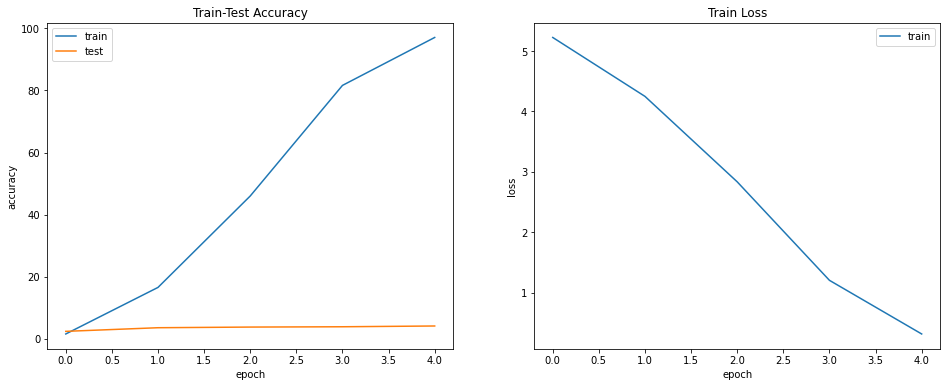

In [ ]:
plot_results(training_accs, training_losses, test_accs)

# Model with 3 convolutional layers

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 3, padding=1)        
        self.conv2 = nn.Conv2d(6, 12, 3, padding=1)        
        self.conv3 = nn.Conv2d(12, 24, 5, padding=2)       
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(24 * 28 * 28, 196)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
                                    
        x = x.view(-1, 24 * 28 * 28)
        logits = self.fc1(x)
        
        return logits
    
model_ft = Net()

In [ ]:
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)
lrscheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=100, gamma=0.1)

In [ ]:
model_ft, training_losses, training_accs, test_accs = train_model(model_ft,
                                                                  criterion,
                                                                  optimizer_ft,
                                                                  lrscheduler, 
                                                                  n_epochs=5)

Epoch 1, duration: 25 s, loss: 5.2815, acc: 0.8946
Test accuracy: 1.6042780748663104
Epoch 2, duration: 26 s, loss: 4.8936, acc: 4.9387
Test accuracy: 2.624051734858848
Epoch 3, duration: 25 s, loss: 3.6472, acc: 24.3015
Test accuracy: 3.8676781494838948
Epoch 4, duration: 25 s, loss: 1.5958, acc: 65.1716
Test accuracy: 3.7681880363138918
Epoch 5, duration: 25 s, loss: 0.3250, acc: 94.0319
Test accuracy: 3.606516602412635
Finished Training


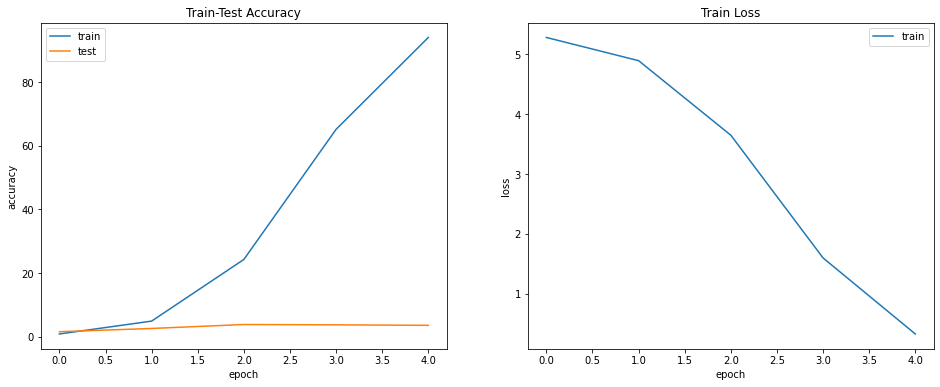

In [ ]:
plot_results(training_accs, training_losses, test_accs)

# Model with 4 convolutional layers

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 3, padding=1)
        self.conv2 = nn.Conv2d(6, 12, 3, padding=1)
        self.conv3 = nn.Conv2d(12, 24, 5, padding=2)
        self.conv4 = nn.Conv2d(24, 48, 5, padding=2)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(48 * 14 * 14, 196)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
                                    
        x = x.view(-1, 48 * 14 * 14)
        logits = self.fc1(x)
        
        return logits
    
model_ft = Net()

In [ ]:
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)
lrscheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=100, gamma=0.1)

In [ ]:
model_ft, training_losses, training_accs, test_accs = train_model(model_ft,
                                                                  criterion,
                                                                  optimizer_ft,
                                                                  lrscheduler, 
                                                                  n_epochs=5)

Epoch 1, duration: 25 s, loss: 5.2475, acc: 0.9926
Test accuracy: 1.5669692824275587
Epoch 2, duration: 26 s, loss: 5.0094, acc: 2.9902
Test accuracy: 2.885213281930108
Epoch 3, duration: 25 s, loss: 4.6029, acc: 7.4387
Test accuracy: 3.7308792438751395
Epoch 4, duration: 25 s, loss: 3.9251, acc: 16.5564
Test accuracy: 4.2283298097251585
Epoch 5, duration: 25 s, loss: 2.9173, acc: 34.6446
Test accuracy: 4.5392364133814205
Finished Training


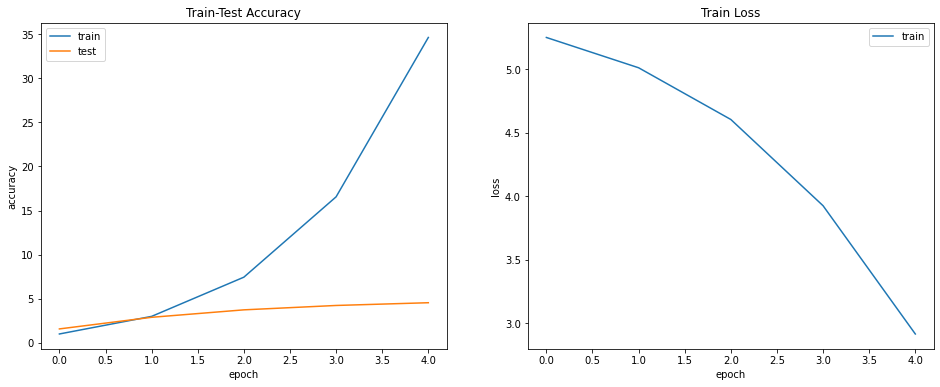

In [ ]:
plot_results(training_accs, training_losses, test_accs)

Models above showed approximately the same result on the test set and it is very difficult to say which of the models is the best because they are all overfitted. However I am sure that after appying regularization, model with 4 convolutional layers will perform better because it will be able to find the most complex patterns.

# Applying Dropout

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 3, padding=1)
        self.dropout1 = nn.Dropout(0.2)
        
        self.conv2 = nn.Conv2d(6, 12, 3, padding=1)
        self.dropout2 = nn.Dropout(0.2)
        
        self.conv3 = nn.Conv2d(12, 24, 5, padding=2)
        self.dropout3 = nn.Dropout(0.5)
        
        self.conv4 = nn.Conv2d(24, 48, 5, padding=2)
        self.dropout4 = nn.Dropout(0.5)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(48 * 14 * 14, 196)

    def forward(self, x):
        x = self.dropout1(self.pool(F.relu(self.conv1(x))))
        x = self.dropout2(self.pool(F.relu(self.conv2(x))))
        x = self.dropout3(self.pool(F.relu(self.conv3(x))))
        x = self.dropout4(self.pool(F.relu(self.conv4(x))))

        x = x.view(-1, 48 * 14 * 14)
        logits = self.fc1(x)

        return logits
    
model_ft = Net()

In [ ]:
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)
lrscheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=100, gamma=0.1)

In [ ]:
model_ft, training_losses, training_accs, test_accs = train_model(model_ft,
                                                                  criterion,
                                                                  optimizer_ft,
                                                                  lrscheduler, 
                                                                  n_epochs=5)

Epoch 1, duration: 25 s, loss: 5.2921, acc: 0.5025
Test accuracy: 0.5471956224350205
Epoch 2, duration: 25 s, loss: 5.2626, acc: 0.8211
Test accuracy: 0.9949011317000372
Epoch 3, duration: 25 s, loss: 5.1837, acc: 1.3358
Test accuracy: 1.6415868673050615
Epoch 4, duration: 25 s, loss: 4.9935, acc: 3.1863
Test accuracy: 2.0892923765700786
Epoch 5, duration: 26 s, loss: 4.7108, acc: 6.3358
Test accuracy: 2.5991792065663475
Finished Training


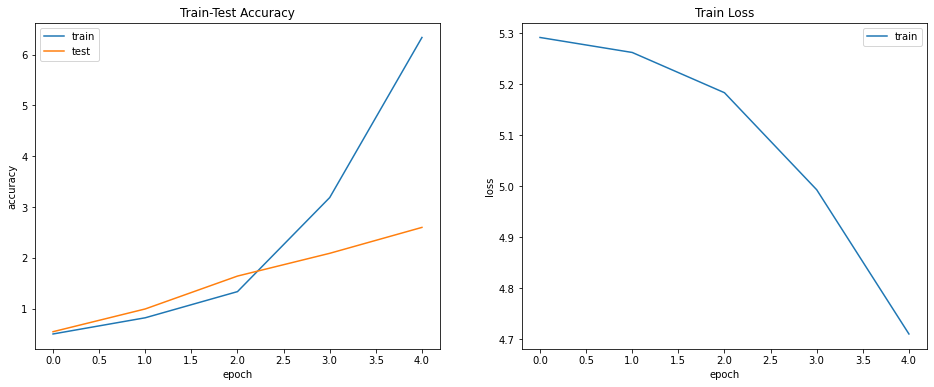

In [ ]:
plot_results(training_accs, training_losses, test_accs)

By adding a dropout, we can see that the model doesn't overfit as before.

# Applying BatchNorm

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 3, padding=1)
        self.dropout1 = nn.Dropout(0.2)
        self.batchnorm1 = nn.BatchNorm2d(6)
        
        self.conv2 = nn.Conv2d(6, 12, 3, padding=1)
        self.dropout2 = nn.Dropout(0.2)
        self.batchnorm2 = nn.BatchNorm2d(12)
        
        self.conv3 = nn.Conv2d(12, 24, 5, padding=2)
        self.dropout3 = nn.Dropout(0.5)
        self.batchnorm3 = nn.BatchNorm2d(24)
        
        self.conv4 = nn.Conv2d(24, 48, 5, padding=2)
        self.dropout4 = nn.Dropout(0.5)
        self.batchnorm4 = nn.BatchNorm2d(48)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(48 * 14 * 14, 196)

    def forward(self, x):
        x = self.batchnorm1(self.dropout1(self.pool(F.relu(self.conv1(x)))))
        x = self.batchnorm2(self.dropout2(self.pool(F.relu(self.conv2(x)))))
        x = self.batchnorm3(self.dropout3(self.pool(F.relu(self.conv3(x)))))
        x = self.batchnorm4(self.dropout4(self.pool(F.relu(self.conv4(x)))))
        
        x = x.view(-1, 48 * 14 * 14)
        logits = self.fc1(x)
        
        return logits
    
model_ft = Net()

In [ ]:
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)
lrscheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=100, gamma=0.1)

In [ ]:
model_ft, training_losses, training_accs, test_accs = train_model(model_ft,
                                                                  criterion,
                                                                  optimizer_ft,
                                                                  lrscheduler,
                                                                  n_epochs=5)

Epoch 1, duration: 25 s, loss: 5.3682, acc: 0.8456
Test accuracy: 1.094391244870041
Epoch 2, duration: 25 s, loss: 5.0726, acc: 2.1691
Test accuracy: 0.8207934336525308
Epoch 3, duration: 32 s, loss: 4.8520, acc: 4.3627
Test accuracy: 1.4052978485263026
Epoch 4, duration: 28 s, loss: 4.6332, acc: 6.7892
Test accuracy: 1.492351697550056
Epoch 5, duration: 29 s, loss: 4.4374, acc: 9.2647
Test accuracy: 2.0892923765700786
Finished Training


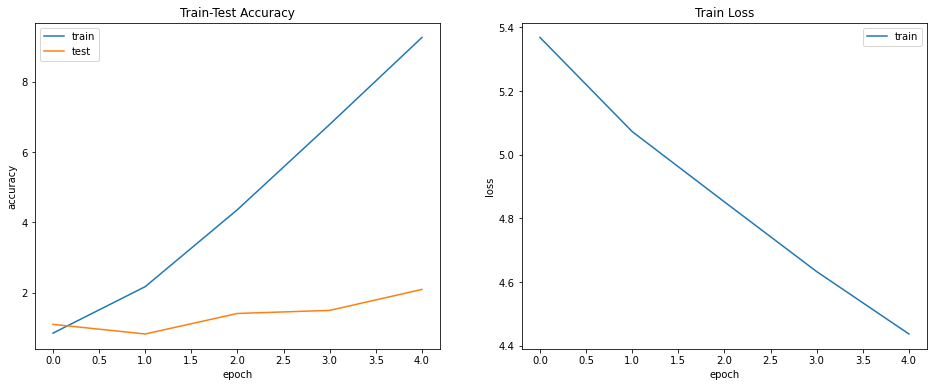

In [ ]:
plot_results(training_accs, training_losses, test_accs)

After adding batch normalization, perfomance on training got better. This happened because batch normalization normalizes the input parameters of the neuron layers, due to which the optimization function converges faster.

# Optimal model configuration

Considering all models, I am sure that the most optimal is the one, that has 4 convolutional layers, dropout and batchnorm. 
Due to the fact that the model has 4 convolutional layers, it can memorize various complex patterns and with the help of a dropout, it will not be overfitted. Also, after applying batch normalization, the model began to train faster.


# Optimal layer sequence

The best layer sequence I have found is 2 layers of 3x3 convolution and 2 layers of 5x5 convolution. On the first layers I decided to use a 3x3 kernel as I think the first layers should find the most primitive patterns (while the latter should find the most difficult ones).

On each layer, the number of filters is doubled, as follows: 16 -> 32 -> 64 -> 128 (LeNet was created in a similar way).

Finally I added 1 more Linear layer to make the model a little more complex.

# Applying augmentation

In [8]:
dataset_dir = 'data/car_data/car_data/'

train_tfms = transforms.Compose([transforms.Resize((256, 256)),
                                 transforms.RandomRotation(20),
                                 transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406],
                                                      [0.229, 0.224, 0.225])
])

test_tfms = transforms.Compose([transforms.Resize((256, 256)),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], 
                                                     [0.229, 0.224, 0.225]) 
])

dataset = torchvision.datasets.ImageFolder(root=dataset_dir + "train", transform = train_tfms)
trainloader = torch.utils.data.DataLoader(dataset, batch_size = 32, shuffle=True, num_workers = 4)

dataset2 = torchvision.datasets.ImageFolder(root=dataset_dir + "test", transform = test_tfms)
testloader = torch.utils.data.DataLoader(dataset2, batch_size = 32, shuffle=False, num_workers = 4)



# Best custom model with 4 convolutional layers

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.dropout1 = nn.Dropout(0)
        self.batchnorm1 = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.dropout2 = nn.Dropout(0)
        self.batchnorm2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, 5, padding=2)
        self.dropout3 = nn.Dropout(0)
        self.batchnorm3 = nn.BatchNorm2d(64)
        
        self.conv4 = nn.Conv2d(64, 128, 5, padding=2)
        self.dropout4 = nn.Dropout(0)
        self.batchnorm4 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(128 * 14 * 14, 1024)
        self.fc2 = nn.Linear(1024, 196)

    def forward(self, x):
        x = self.batchnorm1(self.dropout1(self.pool(F.relu(self.conv1(x)))))
        x = self.batchnorm2(self.dropout2(self.pool(F.relu(self.conv2(x)))))
        x = self.batchnorm3(self.dropout3(self.pool(F.relu(self.conv3(x)))))
        x = self.batchnorm4(self.dropout4(self.pool(F.relu(self.conv4(x)))))
        
        x = x.view(-1, 128 * 14 * 14)
        x = self.fc1(x)
        logits = self.fc2(x)
        
        return logits
    
model_ft = Net()

In [ ]:
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
lrscheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=100, gamma=0.1)

In [ ]:
model_ft, training_losses, training_accs, test_accs = train_model(model_ft,
                                                                  criterion,
                                                                  optimizer_ft,
                                                                  lrscheduler, 
                                                                  n_epochs=200)

Epoch 1, duration: 29 s, loss: 17.6492, acc: 0.7353
Test accuracy: 0.6093769431662729
Epoch 2, duration: 30 s, loss: 9.2172, acc: 0.8333
Test accuracy: 1.1068275090162913
Epoch 3, duration: 29 s, loss: 6.3472, acc: 1.0784
Test accuracy: 1.4301703768188037
Epoch 4, duration: 29 s, loss: 5.9932, acc: 1.2500
Test accuracy: 1.231190150478796
Epoch 5, duration: 30 s, loss: 5.7962, acc: 1.1887
Test accuracy: 1.8032583012063175
Epoch 6, duration: 30 s, loss: 5.5265, acc: 1.5809
Test accuracy: 1.9276209426688222
Epoch 7, duration: 29 s, loss: 5.3014, acc: 1.9363
Test accuracy: 3.3951001119263773
Epoch 8, duration: 29 s, loss: 5.1390, acc: 2.5245
Test accuracy: 3.656261658997637
Epoch 9, duration: 30 s, loss: 4.9920, acc: 3.4926
Test accuracy: 4.52680014923517
Epoch 10, duration: 47 s, loss: 4.8786, acc: 4.5343
Test accuracy: 5.459519960203955
Epoch 11, duration: 36 s, loss: 4.7652, acc: 5.3799
Test accuracy: 5.59631886581271
Epoch 12, duration: 40 s, loss: 4.6713, acc: 6.1765
Test accuracy: 6.

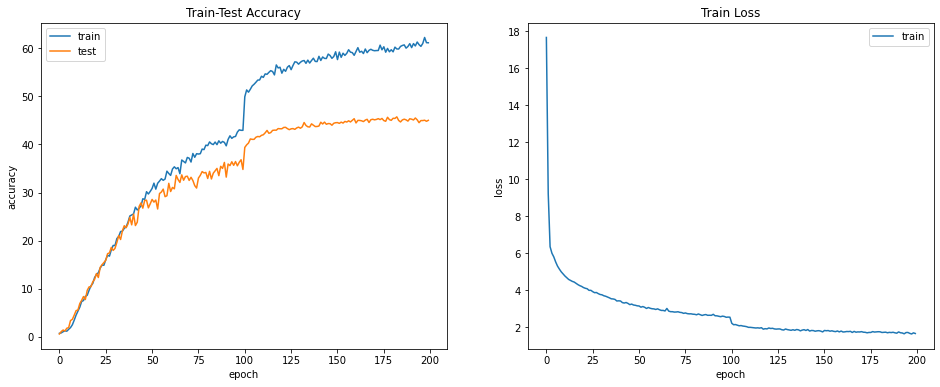

In [ ]:
plot_results(training_accs, training_losses, test_accs)

(On the picture above we can see huge improvement in accuracy after 100 epoch, thanks to decreasing learning_rate by 0.1)

The last version of model better than previous ones because it uses image augmentations which has huge regularization effect. So I didn't used dropout while training model.

# Visualization of filters and activation map

With the help of the activation map, we can see that the model found good filters that paint pictures in contrasting colors and find different edges of objects.

First convolutional layer


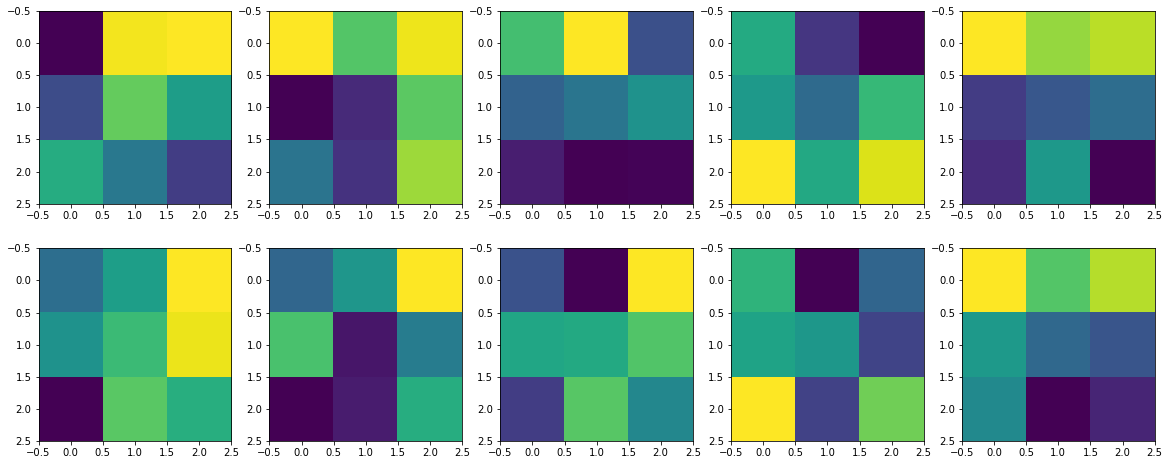

In [ ]:
# Get the weights in the first conv layer
weights = model_ft.conv1.weight.data
weights = weights.cpu()
w = weights.numpy()

# for 10 filters
fig=plt.figure(figsize=(20, 8))
columns = 5
rows = 2
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(w[i][0])
    
print('First convolutional layer')
plt.show()

weights = model_ft.conv2.weight.data
weights = weights.cpu()
w = weights.numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


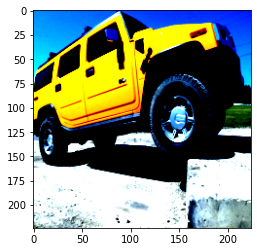

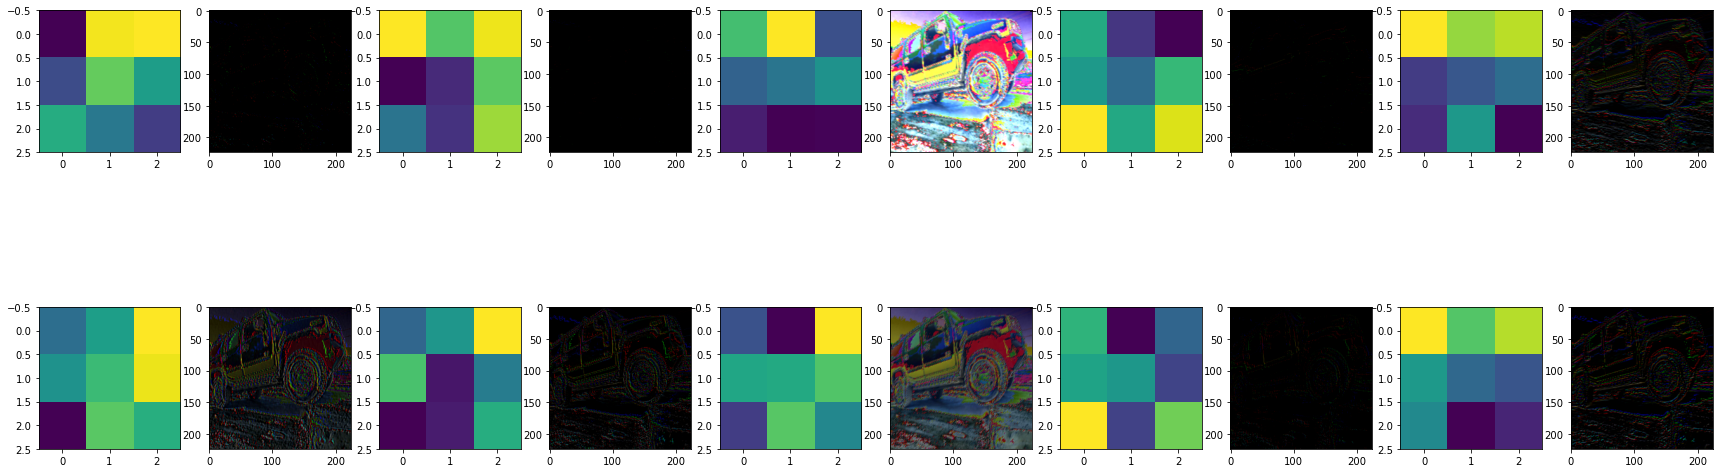

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()
idx = 3
img = images[idx].permute(1,2,0).numpy()
import cv2
plt.imshow(img)

weights = model_ft.conv1.weight.data
w = weights.to('cpu').numpy()
fig=plt.figure(figsize=(30, 10))
columns = 5*2
rows = 2
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0])
    else:
        c = cv2.filter2D((img * 255).astype(np.uint8), -1, w[int((i-1)/2)][0])
        plt.imshow(c)
plt.show()

# Pre-trained model

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
model_ft = models.resnet34(pretrained=True)
for param in model_ft.parameters():
    param.requires_grad = False

num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 196)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)
lrscheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

In [ ]:
model_ft, training_losses, training_accs, test_accs = train_model(model_ft,
                                                                  criterion,
                                                                  optimizer_ft,
                                                                  lrscheduler, 
                                                                  n_epochs=10)

Epoch 1, duration: 126 s, loss: 5.3305, acc: 0.6373
Test accuracy: 1.119263773162542
Epoch 2, duration: 126 s, loss: 5.1865, acc: 1.4951
Test accuracy: 2.4250715085188412
Epoch 3, duration: 127 s, loss: 5.0859, acc: 3.0515
Test accuracy: 3.382663847780127
Epoch 4, duration: 126 s, loss: 4.9895, acc: 4.8039
Test accuracy: 4.651162790697675
Epoch 5, duration: 127 s, loss: 4.8947, acc: 7.2304
Test accuracy: 6.703146374829001
Epoch 6, duration: 126 s, loss: 4.8190, acc: 10.4289
Test accuracy: 7.648302449944038
Epoch 7, duration: 126 s, loss: 4.8026, acc: 11.1642
Test accuracy: 8.24524312896406
Epoch 8, duration: 126 s, loss: 4.7890, acc: 12.2917
Test accuracy: 8.469095883596568
Epoch 9, duration: 127 s, loss: 4.7849, acc: 12.0221
Test accuracy: 8.929237657007835
Epoch 10, duration: 126 s, loss: 4.7711, acc: 12.4877
Test accuracy: 9.090909090909092
Epoch 11, duration: 127 s, loss: 4.7584, acc: 13.3824
Test accuracy: 8.867056336276583
Epoch 12, duration: 126 s, loss: 4.7625, acc: 12.6225
Tes

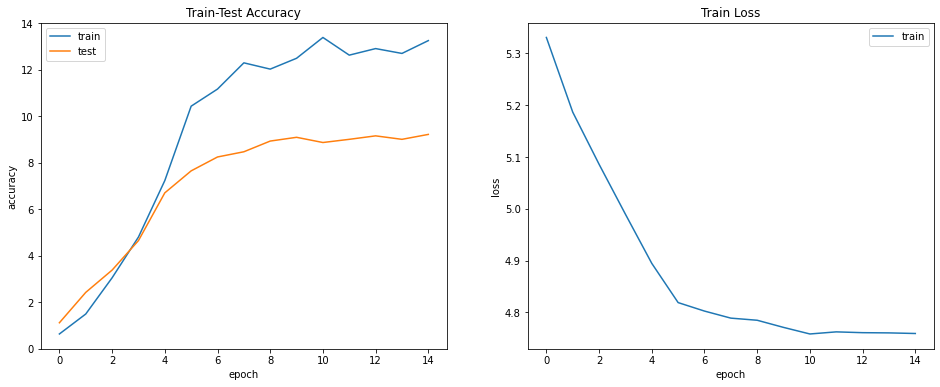

In [ ]:
plot_results(training_accs, training_losses, test_accs)

The result here is much worse than in my previous model, since ResNet50 was trained to classify various images, while the classification of cars is a rather specific task. Since the model parameters are frozen, replacing just one layer is not enough, I think, replacing more output neurons can improve perfomance.

# Fine-tuning a pre-trained model

In [10]:
model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 196)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)
lrscheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

In [11]:
model_ft, training_losses, training_accs, test_accs = train_model(model_ft,
                                                                  criterion,
                                                                  optimizer_ft,
                                                                  lrscheduler,
                                                                  n_epochs=10)

Epoch 1, duration: 93 s, loss: 4.7367, acc: 8.2230
Test accuracy: 23.007088670563363
Epoch 2, duration: 91 s, loss: 3.4335, acc: 29.5343
Test accuracy: 44.82029598308668
Epoch 3, duration: 91 s, loss: 2.5483, acc: 46.6054
Test accuracy: 62.85287899514985
Epoch 4, duration: 91 s, loss: 1.9877, acc: 58.0147
Test accuracy: 66.4096505409775
Epoch 5, duration: 91 s, loss: 1.6123, acc: 64.9755
Test accuracy: 73.29934087800025
Epoch 6, duration: 91 s, loss: 1.3892, acc: 68.7990
Test accuracy: 74.92849148115907
Epoch 7, duration: 91 s, loss: 1.2434, acc: 71.3725
Test accuracy: 77.07996517846038
Epoch 8, duration: 91 s, loss: 1.1068, acc: 74.0074
Test accuracy: 78.6344981967417
Epoch 9, duration: 91 s, loss: 1.0236, acc: 76.1765
Test accuracy: 78.19922895162293
Epoch 10, duration: 91 s, loss: 0.9477, acc: 77.9412
Test accuracy: 81.5445840069643
Finished Training


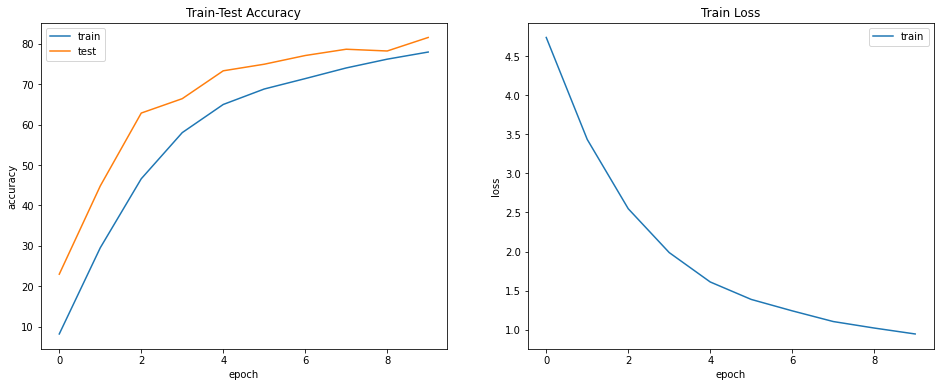

In [12]:
plot_results(training_accs, training_losses, test_accs)

(The accuracy of the model on the validation set was higher, since the accuracy of the training set was calculated before updating the weights, and the accuracy on the validation set was calculated after updating)

The last model performed better, since all of its weights were optimized for the new task (not just the last layer as in the previous model)